In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
dataset_path ='RGB_224x224'

In [12]:
train_dir = os.path.join(dataset_path, 'train')

In [13]:
classes = os.listdir(train_dir)

In [14]:
classes

['Aji pepper plant',
 'Almonds plant',
 'Amaranth plant',
 'Apples plant',
 'Artichoke plant',
 'Avocados plant',
 'Bananas plant',
 'Barley plant',
 'Beets plant',
 'Black pepper plant',
 'Blueberries plant',
 'Bok choy plant',
 'Brazil nuts plant',
 'Broccoli plant',
 'Brussels sprout plant',
 'Buckwheat plant',
 'Cabbages and other brassicas plant',
 'Camucamu plant',
 'Carrots and turnips plant',
 'Cashew nuts plant',
 'Cassava plant',
 'Cauliflower plant',
 'Celery plant',
 'Cherimoya plant',
 'Cherry plant',
 'Chestnuts plant',
 'Chickpeas plant',
 'Chili peppers and green peppers plant',
 'Cinnamon plant',
 'Cloves plant',
 'Cocoa beans plant',
 'Coconuts plant',
 'Coffee (green) plant',
 'Collards plant',
 'Cotton lint plant',
 'Cranberries plant',
 'Cucumbers and gherkins plant',
 'Dates plant',
 'Dry beans plant',
 'Dry peas plant',
 'Durian plant',
 'Eggplants (Aubergines) plant',
 'Endive plant',
 'Fava bean plant',
 'Figs plant',
 'Flax fiber and tow plant',
 'Flaxseed (Li

In [15]:
import random

In [16]:
random.sample(classes, 5)

['Carrots and turnips plant',
 'Mustard greens plant',
 'Parsley plant',
 'Turmeric plant',
 'Pistachios plant']

In [17]:
def show_sample_image(num_classes=4):
    fig, axes = plt.subplots(num_classes, 5, figsize=(15, 3 * num_classes))
    
    for i, class_name in enumerate(random.sample(classes, num_classes)):
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        
        for j in range(5):
            img_path = os.path.join(class_path, images[j])
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    plt.tight_layout()
    
    
        

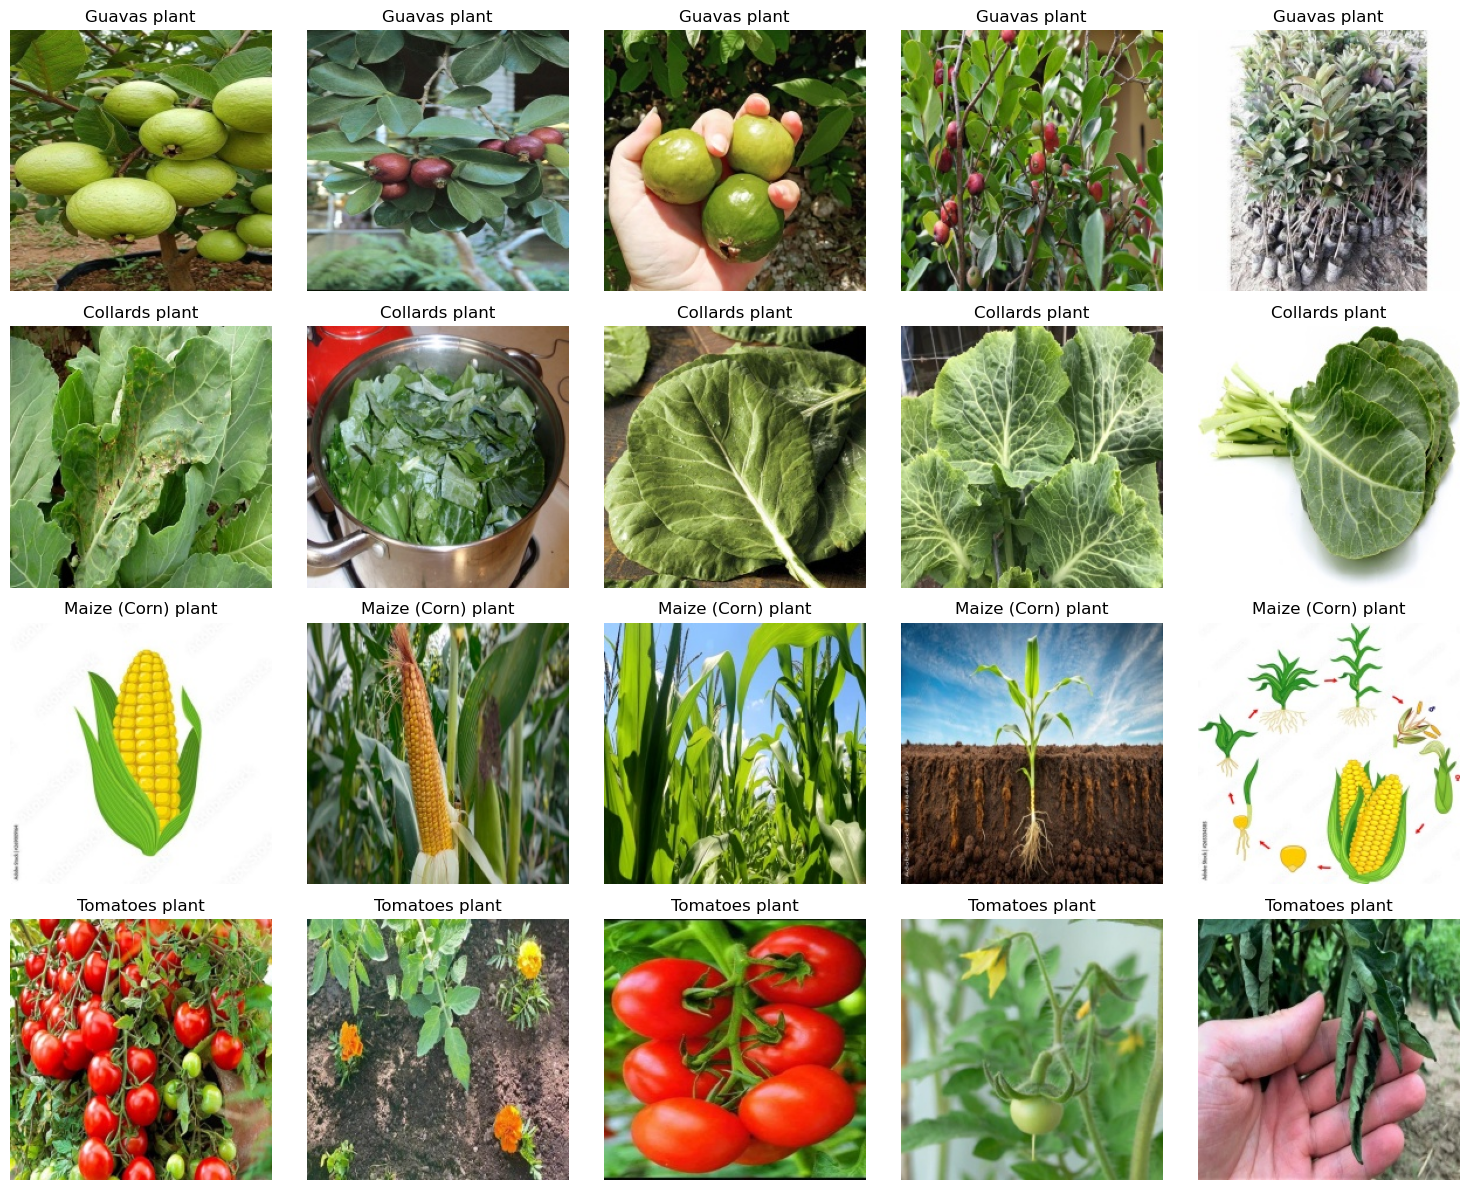

In [18]:
show_sample_image()

In [21]:
!pip install torch torchvision

In [22]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [24]:
train_dataset = ImageFolder(os.path.join(dataset_path, 'train'), transform=transform)
val_dataset = ImageFolder(os.path.join(dataset_path, 'val'), transform=transform)
test_dataset = ImageFolder(os.path.join(dataset_path, 'test'), transform=transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [30]:
import torchvision.models as models
import torch.nn as nn

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
models= models.resnet18(pretrained=True)

C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
for param in models.parameters():
    param.requires_grad = False

In [34]:
num_classes = len(train_dataset.classes)
models.fc = nn.Linear(models.fc.in_features, num_classes)
models = models.to(device)  

In [40]:
import torch.optim as optim
import torch.nn.functional as F

In [41]:
optimizer = optim.Adam(models.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [42]:
def train_one_epoch(model, loader):
    models.train()
    running_loss = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / len(loader)

In [43]:
def evaluate(models, loader):
    models.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = models(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

In [44]:
def visualize_predictions(models, loader, num_images=5):
    models.eval()
    images_shown = 0
    class_names = train_dataset.classes
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = models(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(num_images):
                
                img = images[i].cpu().permute(1, 2, 0).numpy()
                                
                plt.imshow((img*0.229 + 0.485))
                plt.title(f'True: {class_names[labels[i]]}, Pred: {class_names[preds[i]]}')
                plt.axis('off')
                plt.show()
                
                images_shown += 1

                if images_shown >= num_images:
                    return
                

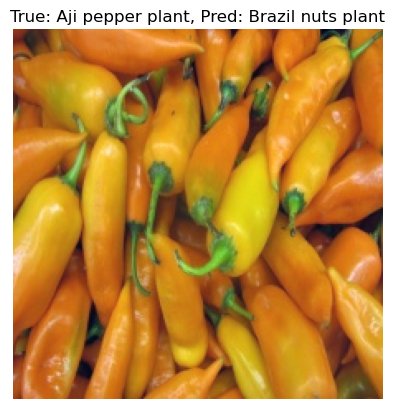

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02352938..1.041143].


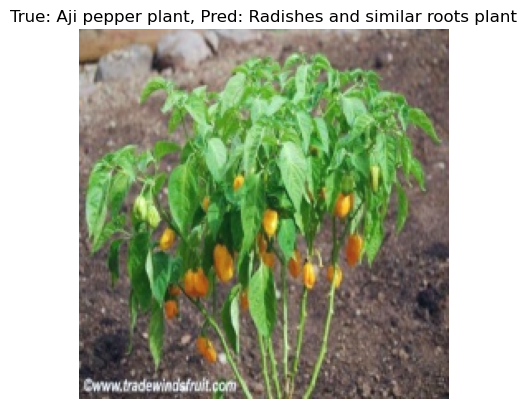

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.08956].


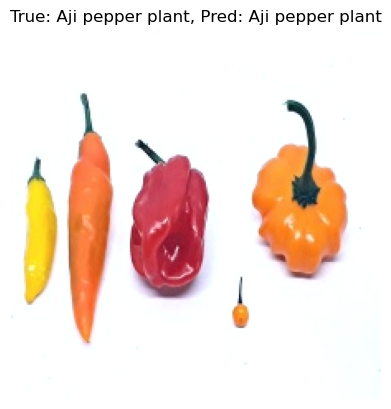

In [48]:
visualize_predictions(models, test_loader, 3)

In [49]:
model_data = {
    'model_state_dict': models.state_dict(),
    'class_to_idx': train_dataset.class_to_idx
}

In [51]:
import joblib

In [52]:
joblib.dump(model_data, 'crop_classification_model.pkl')

['crop_classification_model.pkl']

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import joblib
import io
import streamlit as st  # Added missing import

model_data = joblib.load('crop_classification_model.pkl')

# Create the same model architecture that was used during training
# The error shows the model was trained with ResNet18 (512 features), not ResNet50 (2048 features)
model = models.resnet18(pretrained=False)  # Keeping ResNet18 which has 512 features in final layer

# Check if the model was created with a specific weights version
if 'model_architecture' in model_data:
    # If architecture info is saved, use it to recreate the exact model
    model = model_data['model_architecture']
else:
    # If no architecture info, modify the model to match the saved state dict
    # Fix: Use 512 instead of 2048 as that's the correct size for ResNet18
    num_classes = len(model_data['class_to_idx'])
    model.fc = torch.nn.Linear(512, num_classes)  # Changed from 2048 to 512 for ResNet18

# Load the state dictionary with strict=False to ignore non-matching keys
model.load_state_dict(model_data['model_state_dict'], strict=False)
model.eval()

idx_to_class = {v: k for k, v in model_data['class_to_idx'].items()}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
st.title("Crop Classification")
st.markdown("Upload an image of a crop to predict it.")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"]) 

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption='Uploaded Image', use_container_width=True)
    
    input_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        class_name = idx_to_class[predicted.item()]
    
    st.success(f"Predicted Crop: **{class_name}**")

C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
2025-09-04 10:23:21.207 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 10:23:21.291 
  command:

    streamlit run C:\Users\User\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-04 10:23:21.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 10:23:21.